In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from scipy import stats
import pingouin as pg
import xarray as xr
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import dataframe_image as dfi
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability')
import tool_box

colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

def correlation_matrix_creator(predictors_and_target_df):
    predictors_and_target_df = predictors_and_target_df.to_numpy()
    corr_matrx = []
    for ts_1 in range(len(predictors_and_target_df.T)):
        corr_row = []
        for ts_2 in range(len(predictors_and_target_df.T)):
            timeseries_1 = predictors_and_target_df[:,ts_1]
            timeseries_2 = predictors_and_target_df[:,ts_2]
            N = len(timeseries_1)
            r = stats.pearsonr(timeseries_1[:], timeseries_2[:])[0]
            r1_autocorrelation = stats.pearsonr(timeseries_1[1:], timeseries_1[:-1])[0]
            r2_autocorrelation = stats.pearsonr(timeseries_2[1:], timeseries_2[:-1])[0]
            N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                        (1+r1_autocorrelation*r2_autocorrelation))
            tcrit = stats.t.ppf(1-0.025, N_star)
            t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
            if abs(t) - tcrit > 0:
                significant = 1
            else:
                significant = 0
            corr_row.append([r, significant])
        corr_matrx.append(corr_row)
    return np.array(corr_matrx)

def corr_matrix_plotter(corr_matrx):
    correlation_matrix = corr_matrx[:,:,0]
    correlation_matrix = np.around(correlation_matrix, 2)
    significance_matrix = corr_matrx[:,:,1] 

    # Significance will be dictated in Correlation Matrix with '*'
    sig_str = []
    for row in significance_matrix:
        row_str = []
        for item in row:
            if int(item) == 1:
                row_str.append('*')
            else:
                row_str.append(' ')
        sig_str.append(row_str)
    sig_str = np.array(sig_str)

    corr = correlation_matrix.astype(str)
    matrix = np.triu(np.ones_like(corr_matrx))
    plt.figure(figsize=(len(correlation_matrix),len(correlation_matrix)))
    sns.set_palette("Paired")
    sns.color_palette("Paired")


    # combining text with values
    formatted_text = (np.asarray(["{corr}{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())])).reshape(len(correlation_matrix), len(correlation_matrix))
    #formatted_text = (print(np.asarray(["{corr}\n{sig}".format(corr=corr[:5], sig=sig) for corr, sig in zip(corr.flatten(), sig_str.flatten())]))).reshape(8, 8)

    # plot the heatmap
    matrix = np.triu(np.ones_like(significance_matrix))
    ax = sns.heatmap(correlation_matrix, xticklabels=predictors_and_target_df.columns, 
                yticklabels=predictors_and_target_df.columns, cmap=custom_cmap, 
                annot=formatted_text,  vmin=-1, vmax=1, fmt="",
                annot_kws={"fontsize":12}, mask=matrix, cbar=False)
    for i in range(0, len(matrix)-1):
        for j in range(1, len(matrix[i])):
            if int(matrix[i,j]) == 0:
                continue
            elif i == j:
                continue
            else:
                ax.add_patch(Rectangle((i, j), 1, 1, fill=False, edgecolor='black', lw=1.5))
    return(ax)
    
def lr_table(X, Y1, Y2, Y3, Y4, Y5):
    X = sm.add_constant(X) # adding a constant
    
    lm1 = pg.linear_regression(X, Y1, add_intercept=True, relimp=True)
    lm1 = lm1[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm1 = lm1.round(2)
    r2_y1 = lm1.r2[0]
    adjr2_y1 = lm1.adj_r2[0]
    #################################################################
    lm2 = pg.linear_regression(X, Y2, add_intercept=True, relimp=True)
    lm2 = lm2[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm2 = lm2.round(2)
    r2_y2 = lm2.r2[0]
    adjr2_y2 = lm2.adj_r2[0]
    #################################################################
    lm3 = pg.linear_regression(X, Y3, add_intercept=True, relimp=True)
    lm3 = lm3[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm3 = lm3.round(2)
    r2_y3 = lm3.r2[0]
    adjr2_y3 = lm3.adj_r2[0]
    #################################################################
    lm4 = pg.linear_regression(X, Y4, add_intercept=True, relimp=True)
    lm4 = lm4[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm4 = lm4.round(2)
    r2_y4 = lm4.r2[0]
    adjr2_y4 = lm4.adj_r2[0]
    #################################################################
    lm5 = pg.linear_regression(X, Y5, add_intercept=True, relimp=True)
    lm5 = lm5[['names', 'coef', 'relimp', 'r2', 'adj_r2']]
    lm5 = lm5.round(2)
    r2_y5 = lm5.r2[0]
    adjr2_y5 = lm5.adj_r2[0]
    
    new_df = [
              ['  CPT  ', str(lm1.coef[1]) + '/' + str(lm1.relimp[1]), str(lm1.coef[2]) + '/' +  str(lm1.relimp[2]), str(lm1.coef[3]) + '/' +  str(lm1.relimp[3]), r2_y1, adjr2_y1], 
              ['  CPZ  ', str(lm5.coef[1]) + '/' + str(lm5.relimp[1]), str(lm5.coef[2]) + '/' +  str(lm5.relimp[2]), str(lm5.coef[3]) + '/' +  str(lm5.relimp[3]), r2_y5, adjr2_y5], 
              ['  WV  ',str(lm3.coef[1]) + '/' + str(lm3.relimp[1]), str(lm3.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm3.coef[3]) + '/' +  str(lm3.relimp[3]), r2_y3, adjr2_y3],
              ['  TCF  ',str(lm2.coef[1]) + '/' + str(lm2.relimp[1]), str(lm2.coef[2]) + '/' +  str(lm2.relimp[2]), str(lm2.coef[3]) + '/' +  str(lm2.relimp[3]), r2_y2, adjr2_y2],
              ['  ACF  ',str(lm4.coef[1]) + '/' + str(lm4.relimp[1]), str(lm4.coef[2]) + '/' +  str(lm3.relimp[2]), str(lm4.coef[3]) + '/' +  str(lm4.relimp[3]), r2_y4, adjr2_y4]]
    
    new_df = pd.DataFrame(new_df)
    new_df.columns = ['       ', ' QBO ', ' BDC ', ' ENSO ', 'R2', 'adj R2']    
    table_text = new_df.to_latex(index=False, na_rep='NA')
    #table_text_w_caption = table_text[:19] + '\n\caption {$R^{2}$ = } \label{tab:title} ' + table_text[19:]
    print(table_text)

def cf_profile_finder(cf_prof_maps):
    cf_prof_maps_ = np.sort(cf_prof_maps)
    profile_cf = np.array([np.load(cf_prof_maps_[yr])[0] for yr in range(len(cf_prof_maps_))])
    empty_prof_map = np.empty(np.shape(profile_cf[:5]))
    empty_prof_map[:] = np.NaN
    profile_cf = np.concatenate((empty_prof_map, profile_cf), axis=0)
    profile_cf = np.reshape(profile_cf, (15,12,24,144,221))
    profile_cf[10,1] = np.nanmean([profile_cf[10,0], profile_cf[10,2]], axis=0)
    profile_cf_anoms = profile_cf - np.nanmean(profile_cf, axis=0)
    profile_cf_anoms_zm = np.nanmean(np.reshape(profile_cf_anoms, (15,12,24*144,221)), axis=2)
    return(profile_cf_anoms_zm)

def season_finder(calendar, m1, m2, m3, m4, m5):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3], calendar[:,m4],
                            calendar[:,m5]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1]))
    return(total_djf_timeseries)

def season_finder_profiles(calendar, m1, m2, m3, m4, m5):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3], calendar[:,m4],
                            calendar[:,m5]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1],shape[2]))
    return(total_djf_timeseries)

def seasonal_mlr_by_height(targets, predictors):
    """
    targets should be an array with: [TTL cirrus, All cf, other 
                                      cirrus, opaque cirrus, temps, 
                                      water vapor]
    predictors should be: [ENSO, QBO, BDC]
    """

    r2_std_ttl = []
    r2_std_all = []
    r2_std_other = []
    r2_std_opaque = []
    r2_std_temp = []
    r2_std_wv = []

    profile_cf_tropical_mean = targets[0]
    profile_all_cf_anoms_zm = targets[1]
    profile_transparent_anoms_zm = targets[2]
    profile_opaque_anoms_zm = targets[3]
    temps_tropical_mean = targets[4]
    wv_tropical_mean = targets[5]

    enso = predictors[0]
    qbo = predictors[1]
    bdc = predictors[2]

    for height in range(0, 100):
        ttl_at_height = profile_cf_tropical_mean[:,height]
        all_at_height = profile_all_cf_anoms_zm[:,height + 120]
        other_at_height = profile_transparent_anoms_zm[:,height + 120]
        opaque_at_height = profile_opaque_anoms_zm[:,height + 120]
        temps_at_height = temps_tropical_mean[:,height]
        
        predictors_and_target = [temps_at_height, ttl_at_height, all_at_height, 
                                 other_at_height, opaque_at_height, enso, 
                                 qbo, bdc]
        predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                                columns=['TEMP','TTL', 'ALL', 'OTHER', 'OPAQUE',
                                                        'ENSO', 'QBO', 'BDC'])

        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['TTL']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_ttl.append([lsd_r2, np.nanstd(ttl_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['ALL']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_all.append([lsd_r2, np.nanstd(all_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['OTHER']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_other.append([lsd_r2, np.nanstd(other_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['OPAQUE']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_opaque.append([lsd_r2, np.nanstd(opaque_at_height)])
        ####################################
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['TEMP']
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_temp.append([lsd_r2, np.nanstd(temps_at_height)])
        
    for height in range(6, 20):
        wv_at_height = wv_tropical_mean[:,height]
        predictors_and_target = [wv_at_height, enso, qbo, bdc]
        predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                                columns=['wv', 'ENSO', 'QBO', 'BDC'])
        X = predictors_and_target_df[['BDC', 'QBO', 'ENSO',]]
        Y = predictors_and_target_df['wv']
        ####################################
        lm = pg.linear_regression(X, Y, add_intercept=True, relimp=True)
        lsd_r2 = lm.r2[0]
        r2_std_wv.append([lsd_r2, np.nanstd(wv_at_height)])

    r2_std_ttl = np.array(r2_std_ttl)
    r2_std_all = np.array(r2_std_all)
    r2_std_other = np.array(r2_std_other)
    r2_std_opaque = np.array(r2_std_opaque)
    r2_std_temp = np.array(r2_std_temp)
    r2_std_wv = np.array(r2_std_wv)

    return(r2_std_ttl, r2_std_all, r2_std_other,r2_std_opaque, r2_std_temp, r2_std_wv)

def r2_plotting(r2_std_ttl, r2_std_all, r2_std_other,r2_std_opaque, r2_std_temp, r2_std_wv, suptitle):
    heights = np.linspace(12,22, 100)
    pressures = [316.22775, 261.01572, 215.4434, 177.82794, 146.77992, 121.15276, 100., 
                82.54042, 68.1292, 56.23413, 46.41589, 38.311867, 31.622776, 26.101572]
    fig, axs = plt.subplots(1,2,figsize=(9,6))
    ####################################################################################
    axs[0].set_xlabel('$\sigma$', fontsize=14)
    axs[0].set_ylabel('Height (km)', fontsize=14)
    axs[0].plot(r2_std_all[:,1]*50, heights, label="All", color='blue', linewidth=2)
    axs[0].plot(r2_std_ttl[:,1]*50, heights, label="TTL", color='blue', linewidth=1, linestyle='--')
    axs[0].plot(r2_std_other[:,1]*50, heights, label="Other", color='blue', linewidth=1, linestyle='dotted')
    axs[0].plot(r2_std_opaque[:,1]*50, heights, label="Opaque", color='blue', linewidth=1, linestyle='dashdot')
    axs[0].plot(r2_std_temp[:,1], heights, label="WV", color='firebrick', linewidth=1.6)
    axs[0].plot(r2_std_temp[:,1], heights, label="Temp", color='black', linewidth=2)
    ax0y = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
    ax0y.plot(r2_std_wv[:,1]*1e6, pressures, label="Water Vapor", color='firebrick', linewidth=2)
    #ax0y.set_ylabel('Pressure (hPa)', color='black', fontsize=14)  # we already handled the x-label with axs[0]
    ax0y.tick_params(axis='y')

    axs[0].legend(frameon=False)
    axs[0].grid(color='grey', linestyle='-', linewidth=.5, alpha=.5)
    axs[0].set_ylim(12,21)
    axs[0].set_xlim(0,0.8)
    ax0y.set_xlim(0,2)
    ax0y.set_ylim(50,180)
    ax0y.set_ylim(ax0y.get_ylim()[::-1])
    ax0y.set_yscale('log')
    plt.title("Interannual Variability \nStandard Deviation", fontsize=14)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ####################################################################################
    axs[1].set_xlabel('$R^{2}$', fontsize=14)
    #axs[1].set_ylabel('Height (km)', fontsize=14)
    axs[1].plot(r2_std_all[:,0], heights, label="All clouds", color='blue', linewidth=2)
    axs[1].plot(r2_std_ttl[:,0], heights, label="TTL cirrus", color='blue', linewidth=1, linestyle='--')
    axs[1].plot(r2_std_other[:,0], heights, label="Other clouds", color='blue', linewidth=1, linestyle='dotted')
    axs[1].plot(r2_std_opaque[:,0], heights, label="Opaque clouds", color='blue', linewidth=1, linestyle='dashdot')
    axs[1].plot(r2_std_temp[:,0], heights, label="WV", color='firebrick', linewidth=1.6)
    axs[1].plot(r2_std_temp[:,0], heights, label="Temp", color='black', linewidth=2)
    ax0y = axs[1].twinx()  # instantiate a second axes that shares the same x-axis
    ax0y.plot(r2_std_wv[:,0], pressures, label="Water Vapor", color='firebrick', linewidth=2)
    ax0y.set_ylabel('Pressure (hPa)', color='black', fontsize=14)  # we already handled the x-label with axs[0]
    ax0y.tick_params(axis='y')

    #axs[1].legend(frameon=False)
    axs[1].grid(color='grey', linestyle='-', linewidth=.5, alpha=.5)
    axs[1].set_ylim(12,21)
    axs[1].set_xlim(0,0.8)
    ax0y.set_xlim(0,0.8)
    ax0y.set_ylim(50,180)
    ax0y.set_ylim(ax0y.get_ylim()[::-1])
    ax0y.set_yscale('log')
    plt.title("$R^{2}$ \nMLR: a*QBO + b*BDC + c*ENSO", fontsize=14)
    plt.suptitle(suptitle, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Pull in timeseries
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'
cpts, cpzs, total_cf, temp_profs, profiles_cf, allTCFCalendarMaps, mjo_index, enso_index, qbo_index, bdc_mf, bdc_eddy, wv_calendar = tool_box.starter()


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


IndexError: too many indices for array

In [ ]:
# get tropical temperature profs and cpt
temp_profs_TTL = temp_profs[:,:,24:48,:,70:170]
cpts_TTL = cpts.copy()
cpzs_TTL = cpzs.copy()

# also get the vertical temperature gradient
vert_temp_grad_profs = tool_box.vert_temp_gradient(temp_profs_TTL)

# Find anomalies or reshape indices 
cpts_anomalies = tool_box.anomaly_finder(cpts_TTL)
cpzs_anomalies = tool_box.anomaly_finder(cpzs_TTL)
temp_anomalies = tool_box.anomaly_finder(temp_profs_TTL)
vert_tempGrad_anomalies = tool_box.anomaly_finder(vert_temp_grad_profs)
vert_tanomGrad_anomalies = tool_box.vert_temp_gradient(temp_anomalies)
total_cf_anomalies = tool_box.anomaly_finder(total_cf)
allTCF_anomalies = tool_box.anomaly_finder(allTCFCalendarMaps)
profile_cf_anomalies = tool_box.anomaly_finder(profiles_cf)
wv_calendar_anoms = wv_calendar - np.nanmean(wv_calendar, axis=0)
wv_anoms_16NS_UTLS = np.nanmean(wv_calendar_anoms[:,:,:,18:27], axis=3)
wv_calendar_ts = np.reshape(wv_anoms_16NS_UTLS, (17*12,55))[1:-11]
wv_calendar_ = np.reshape(wv_calendar_ts, (16,12,55))
wv_ts = wv_calendar_[:,:,12].ravel()
#wv_ts = np.insert(wv_ts, 192, wv_ts[-1])[1:]

# Find the average over 15S-15N
cpt_tropical_mean = tool_box.tropical_average(cpts_anomalies)
cpz_tropical_mean = tool_box.tropical_average(cpzs_anomalies)
temps_tropical_mean = tool_box.tropical_average(temp_anomalies)
vert_tempGrad_tropical_mean = tool_box.tropical_average(vert_tempGrad_anomalies)
vert_tanomGrad_tropical_mean = tool_box.tropical_average(vert_tanomGrad_anomalies)
total_cf_tropical_mean = tool_box.tropical_average(total_cf_anomalies[:,:,:,:])
profile_cf_tropical_mean = tool_box.tropical_average(profile_cf_anomalies)
allcfTCF_tropical_mean = tool_box.tropical_average(allTCF_anomalies)

o3_calendar = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/fileCreators/o3_calendar_raw.npy')
o3_calendar = o3_calendar - np.nanmean(o3_calendar, axis=0)
o3_calendar_ts = np.reshape(o3_calendar, (17*12,55,45))[12:]
o3_calendar = np.reshape(o3_calendar_ts, (16,12,55,45))
o3_ts_anoms_data = np.reshape(o3_calendar, (16*12,55,45))
o3_anoms_ts = np.reshape(o3_ts_anoms_data, (192,55,45))
o3_equatorial_anoms = np.nanmean(o3_anoms_ts[:,13,19:26], axis=1)

/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:109: RuntimeWarning: Mean of empty slice
  dt_dz_new = np.nanmean([dt_dz_1, dt_dz_2], axis=0)
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:85: RuntimeWarning: Mean of empty slice
  seasonal_average = np.nanmean(data_calendar, axis=0)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:138: RuntimeWarning: invalid value encountered in true_divide
  tropical_mean = np.nansum(tropical_data_reshaped, axis=2)/np.nansum(tropical_weights_reshaped, axis=2)
/home/disk/p/aodhan/cf_physical_parameters_correlations/TTLVariability/tool_box.py:133: RuntimeWarning: invalid value encountered in true_divide
  nanned_w

In [ ]:
# The targets we want to predict 
cpt_cal = cpt_tropical_mean
cpz_cal = cpz_tropical_mean
ttl_cirrus_cf_cal = total_cf_tropical_mean
wv_100hpa_cal = np.reshape(wv_ts, (16,12))
allcfTCF_cal = allcfTCF_tropical_mean
o3_cal = np.reshape(o3_equatorial_anoms, (16,12))

# Large Scale Dynamics w/leads
mjo_cal = np.load('/home/disk/p/aodhan/large_scale_dynamics/mjo_vpm_pc2_index.npy')[-192:].reshape((16,12))

#Trop_upwelling = np.load(project_path + '/fileCreators/upwelling_indices/MF_15NS_100hPa_1979_2021.npy')[-192:]
Trop_upwelling = np.load('/home/disk/p/aodhan/cf_physical_parameters_correlations/fileCreators/wstar100_15NS.npy')
Trop_upwelling_cal = Trop_upwelling.reshape(16,12)
Trop_upwelling_anoms = Trop_upwelling_cal - np.nanmean(Trop_upwelling_cal, axis=0)
UP100_cal = Trop_upwelling_anoms
raw_UP100_cal = UP100_cal
BDC_EHF = np.load('/home/disk/p/aodhan/large_scale_dynamics/BDC_100hPa_EHF_3mrm.npy')[-192:]
bdc_ehf_cal = BDC_EHF.reshape(16,12)
bdc_ehf_cal_anoms = bdc_ehf_cal - np.nanmean(bdc_ehf_cal, axis=0)
bdc_cal = bdc_ehf_cal_anoms
qbo_ts = np.load(project_path + '/fileCreators/u50hPa_10NS_1979_2021.npy')[-204:]
qbo_cal = qbo_ts.reshape(17,12)
qbo_cal = qbo_cal - np.nanmean(qbo_cal[1:], axis=0)
qbo_cal  = qbo_cal.ravel()[-194:-2]
qbo_cal = qbo_cal.reshape(16,12)
enso_cal = np.load(project_path + '/fileCreators/T500_15NS_500hPa_2006_2021.npy')[-192:].reshape((16,12))

In [ ]:
def detrender(cal):
    ts = cal.reshape(16*12)[5:]
    time = np.linspace(200.65, 202.2, 187) # time (in decades)
    trends_and_significance = []
    all_detrended_timeseries = []
    regression = stats.linregress(time, ts)

    # find residual timeseries
    ts_trend = regression[0]
    temp_linear_trend = regression[1] + ts_trend*time
    detrended_ts = ts - temp_linear_trend

    nans = np.empty(5)
    nans[:] = np.NaN

    ts_w_nans = np.concatenate((nans, detrended_ts), axis=0)
    cal_detrended = np.reshape(ts_w_nans, np.shape(cal))
    return(cal_detrended)

cpt_cal = detrender(cpt_cal)
cpz_cal = detrender(cpz_cal)
ttl_cirrus_cf_cal = detrender(ttl_cirrus_cf_cal)
wv_100hpa_cal = detrender(wv_100hpa_cal)
allcfTCF_cal = detrender(allcfTCF_cal)
o3_cal = detrender(o3_cal)
mjo_cal = detrender(mjo_cal)
bdc_cal = detrender(bdc_cal)
UP100_cal = detrender(UP100_cal)
rawUP100_cal = detrender(raw_UP100_cal)
qbo_cal = detrender(qbo_cal)
enso_cal = detrender(enso_cal)

In [ ]:
detrended_upwelling = UP100_cal.ravel()[5:]
detrended_qbo = qbo_cal.ravel()[5:]
detrended_T500 = enso_cal.ravel()[5:]
detrended_bdc = bdc_cal.ravel()[5:]

upwelling_df = pd.DataFrame(np.transpose([detrended_T500, detrended_qbo, detrended_bdc, detrended_upwelling]), columns=['T500', 'QBO', 'BDC', 'upwelling'])
upwelling_MLR = pg.linear_regression(upwelling_df[['T500', 'QBO', 'BDC']], upwelling_df['upwelling'], relimp=True)
qbo_enso_bdc_fit = upwelling_MLR.coef[0] + upwelling_df['T500']*upwelling_MLR.coef[1] + upwelling_df['QBO']*upwelling_MLR.coef[2] + upwelling_df['BDC']*upwelling_MLR.coef[3] 
UpwellingRemovedFit = detrended_upwelling - qbo_enso_bdc_fit
up100 = np.concatenate(([np.nan, np.nan, np.nan, np.nan, np.nan], UpwellingRemovedFit), axis=0)
UP100_cal = np.reshape(up100, (16,12))

# NDJFM

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


\begin{tabular}{llllrr}
\toprule
        &       QBO  &       BDC  &      ENSO  &   R2 &  adj R2 \\
\midrule
  CPT   &  0.54/0.27 & -0.15/0.02 & -0.24/0.04 & 0.33 &    0.30 \\
  CPZ   & -0.47/0.17 &   0.08/0.0 &  0.65/0.37 & 0.55 &    0.53 \\
   WV   &  0.48/0.25 &  -0.06/0.0 &   0.27/0.1 & 0.36 &    0.33 \\
  TCF   & -0.35/0.09 &  0.26/0.06 &  0.53/0.25 & 0.40 &    0.38 \\
  ACF   & -0.33/0.09 &   0.18/0.0 &  0.39/0.13 & 0.24 &    0.21 \\
\bottomrule
\end{tabular}



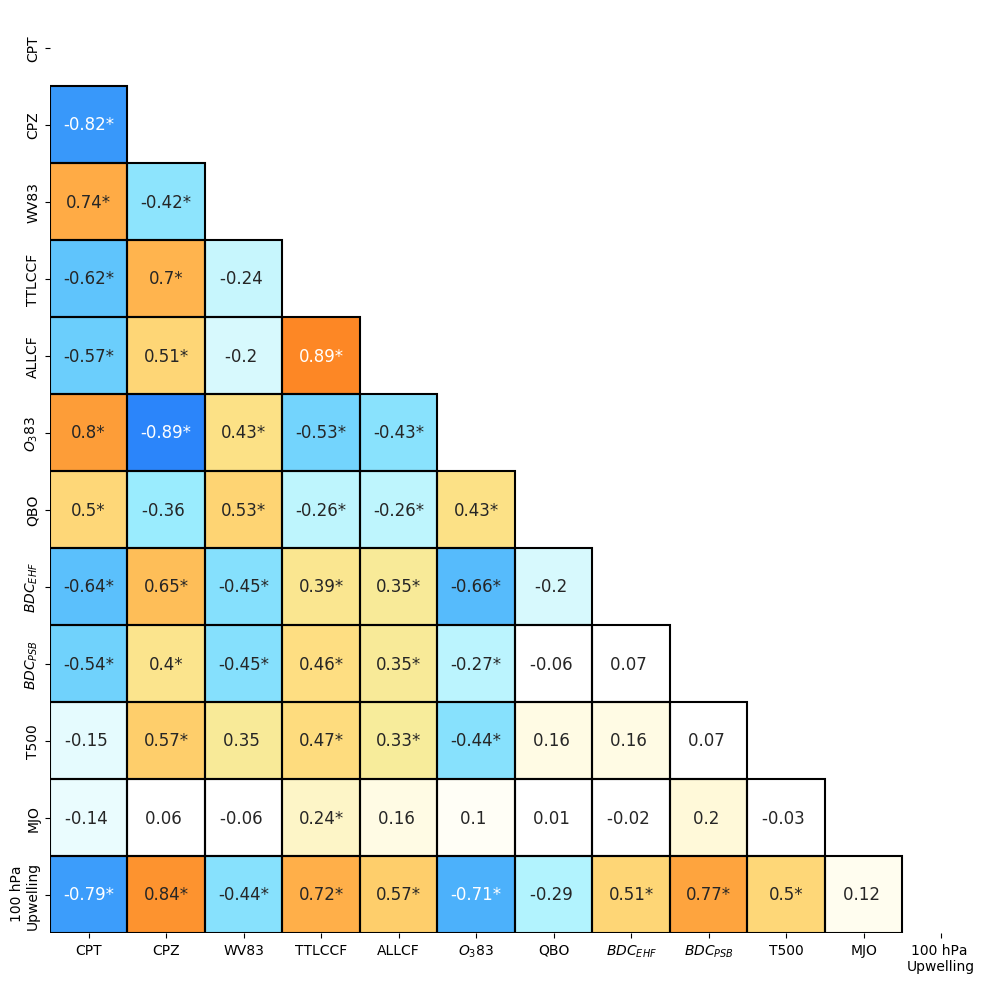

In [ ]:
# Targets
cf_bw = season_finder(ttl_cirrus_cf_cal, 0,1,2,10,11)[3:]
allcf_bw = season_finder(allcfTCF_cal, 0,1,2,10,11)[3:]
cpt_bw = season_finder(cpt_cal, 0,1,2,10,11)[3:]
cpz_bw = season_finder(cpz_cal, 0,1,2,10,11)[3:]
wv_bw = season_finder(wv_100hpa_cal, 0,1,2,10,11)[3:]
o3_bw = season_finder(o3_cal, 0,1,2,10,11)[3:]

# Predictors
mjo_bw = season_finder(mjo_cal, 0,1,2,10,11)[3:]
enso_bw = season_finder(enso_cal, 0,1,2,10,11)[3:]
qbo_bw = season_finder(qbo_cal, 0,1,2,10,11)[3:]
bdc_bw = season_finder(bdc_cal, 0,1,2,10,11)[3:]
up100_bw = season_finder(UP100_cal, 0,1,2,10,11)[3:]
rawup100_bw = season_finder(rawUP100_cal, 0,1,2,10,11)[3:]




predictors_and_target_original = [cpt_bw, cpz_bw, wv_bw, cf_bw, allcf_bw, o3_bw, qbo_bw, bdc_bw, up100_bw, enso_bw, mjo_bw, rawup100_bw]
predictors_and_target = [predictors_and_target_original[i]/np.nanstd(predictors_and_target_original[i]) for i in range(len(predictors_and_target_original))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                        columns=['CPT','CPZ', 'WV83', 'TTLCCF', 'ALLCF', '$O_{3}83$', 
                                                'QBO', '$BDC_{EHF}$', '$BDC_{PSB}$', 'T500', 'MJO', '100 hPa \nUpwelling'])

# Create Correlation and Siginficance Matrices                                                                               
corr_matrix = correlation_matrix_creator(predictors_and_target_df)

# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrix)

# Create Linear Regression Models    
X = predictors_and_target_df[['QBO', 'MJO', 'T500']]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['TTLCCF']
Y3 = predictors_and_target_df['WV83']
Y4 = predictors_and_target_df['ALLCF']
Y5 = predictors_and_target_df['CPZ']
lr_table(X, Y1, Y2, Y3, Y4, Y5)

djf_predictors_and_target_df = predictors_and_target_df

# MLR Test
#test = predictors_and_target_df[['QBO', 'BDC']]
#lm = pg.linear_regression(test, Y2, add_intercept=True, relimp=True)
#lm = lm[['names', 'coef', 'r2', 'adj_r2', 'relimp']]
#display(lm)


# Mar-Apr-May

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


\begin{tabular}{llllrr}
\toprule
        &       QBO  &       BDC  &     ENSO  &   R2 &  adj R2 \\
\midrule
  CPT   &   0.6/0.37 & -0.25/0.06 & -0.2/0.03 & 0.46 &    0.44 \\
  CPZ   &  -0.32/0.1 &   0.08/0.0 &  0.65/0.4 & 0.50 &    0.48 \\
   WV   &  0.65/0.42 &  -0.1/0.02 & 0.06/0.01 & 0.45 &    0.42 \\
  TCF   & -0.37/0.13 &   0.2/0.03 & 0.37/0.12 & 0.29 &    0.26 \\
  ACF   & -0.52/0.26 &  0.05/0.02 & 0.19/0.03 & 0.30 &    0.27 \\
\bottomrule
\end{tabular}



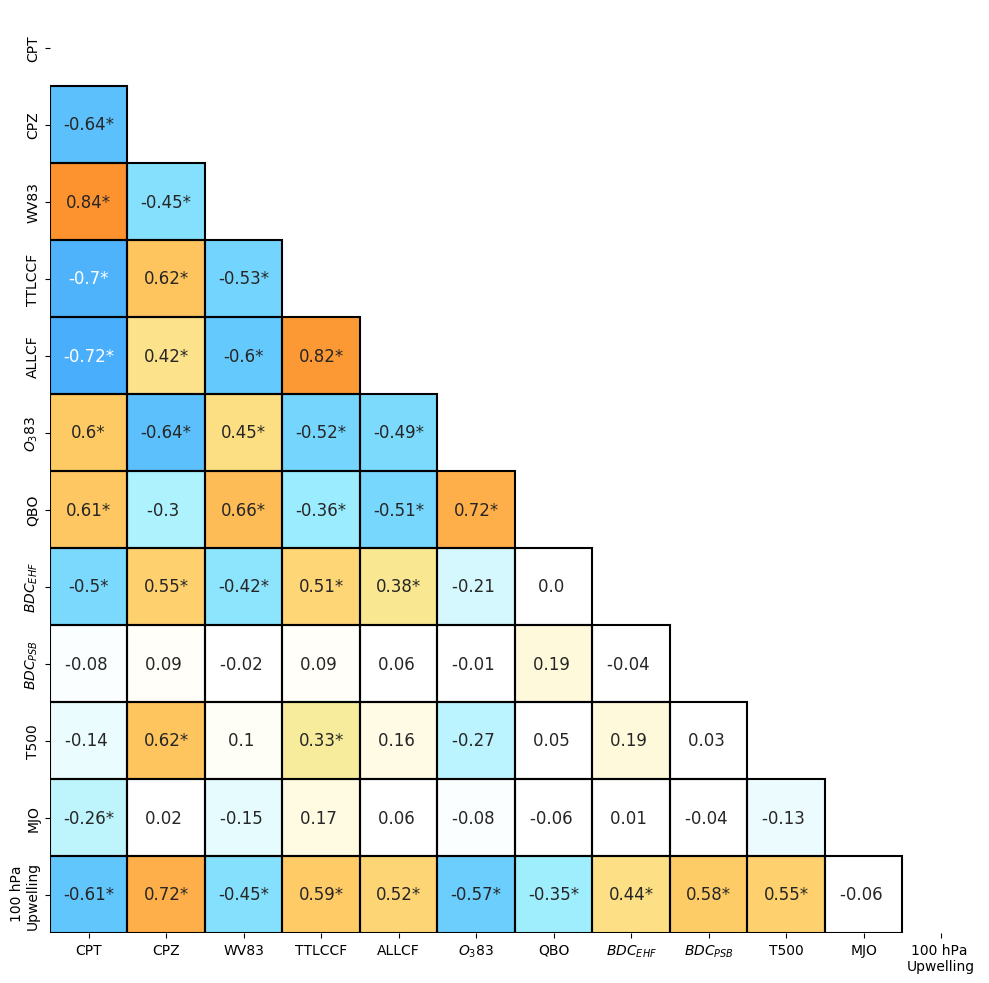

In [ ]:
# Targets
cf_bs = season_finder(ttl_cirrus_cf_cal, 4,5,6,7,8)[1:]
allcf_bs = season_finder(allcfTCF_cal, 4,5,6,7,8)[1:]
cpt_bs = season_finder(cpt_cal, 4,5,6,7,8)[1:]
cpz_bs = season_finder(cpz_cal, 4,5,6,7,8)[1:]
wv_bs = season_finder(wv_100hpa_cal, 4,5,6,7,8)[1:]
o3_bs = season_finder(o3_cal, 4,5,6,7,8)[1:]


# Predictors
mjo_bs = season_finder(mjo_cal, 4,5,6,7,8)[1:]
enso_bs = season_finder(enso_cal, 4,5,6,7,8)[1:]
qbo_bs = season_finder(qbo_cal, 4,5,6,7,8)[1:]
bdc_bs = season_finder(bdc_cal, 4,5,6,7,8)[1:]
up100_bs = season_finder(UP100_cal, 4,5,6,7,8)[1:]
rawup100_bs = season_finder(rawUP100_cal, 4,5,6,7,8)[1:]

predictors_and_target_original = [cpt_bs, cpz_bs, wv_bs, cf_bs, allcf_bs, o3_bs, qbo_bs, bdc_bs, up100_bs, enso_bs, mjo_bs, rawup100_bs]
predictors_and_target = [predictors_and_target_original[i]/np.nanstd(predictors_and_target_original[i]) for i in range(len(predictors_and_target_original))]
predictors_and_target_df = pd.DataFrame(np.transpose(predictors_and_target), 
                                        columns=['CPT','CPZ', 'WV83', 'TTLCCF', 'ALLCF', '$O_{3}83$', 'QBO', '$BDC_{EHF}$', '$BDC_{PSB}$', 'T500', 
                                                 'MJO', '100 hPa \nUpwelling'])

# Create Correlation and Siginficance Matrices                                                                               
corr_matrix = correlation_matrix_creator(predictors_and_target_df)

# Plot correlation Matrix
heatmap = corr_matrix_plotter(corr_matrix)

# Create Linear Regression Models    
X = predictors_and_target_df[['QBO', 'MJO', 'T500',]]
Y1 = predictors_and_target_df['CPT']
Y2 = predictors_and_target_df['TTLCCF']
Y3 = predictors_and_target_df['WV83']
Y4 = predictors_and_target_df['ALLCF']
Y5 = predictors_and_target_df['CPZ']
lr_table(X, Y1, Y2, Y3, Y4, Y5)

jja_predictors_and_target_df = predictors_and_target_df



In [ ]:
djf_predictors_and_target_df

,CPT,CPZ,WV83,TTLCCF,ALLCF,$O_{3}83$,QBO,$BDC_{EHF}$,$BDC_{PSB}$,T500,MJO,100 hPa \nUpwelling
0,1.524182,-0.645677,1.383530,0.122820,0.001988,0.072628,1.125805,-1.249832,-0.663450,0.085637,-1.277609,-1.128618
1,0.934206,-0.460463,0.927923,0.853877,0.614696,0.608901,0.984254,-0.079692,-0.243956,0.949056,-1.702887,-0.028827
2,-0.012364,0.634328,1.049966,1.392404,0.624880,0.124855,0.828403,-0.394852,0.844405,1.816957,1.679483,1.045114
3,0.614779,0.684915,1.065289,-0.613088,-1.301034,-0.698950,0.967886,1.700353,-1.904389,0.934720,-0.329807,-0.593379
4,0.707280,-0.130970,0.860439,-0.532577,-0.763927,-0.119829,0.904778,0.064657,-0.932989,0.326466,2.080442,-0.714518
...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.903631,-1.026700,-0.371150,-1.190950,-1.207536,1.199895,0.244133,0.238263,-0.776796,-1.216250,0.730711,-1.056879
73,-0.006883,-0.783917,0.070478,-0.794864,-0.184549,0.385316,0.290734,0.588002,-1.043905,-1.277192,1.947203,-1.164475
74,0.779295,-1.063695,0.026863,-1.676289,-1.682827,0.490263,0.594581,-0.739718,0.380000,-1.336579,-0.298918,-0.717852
75,1.130703,-0.673248,0.534153,-1.353558,-1.922913,1.060447,0.026134,-1.197865,0.487753,-0.550744,-0.604278,-0.309268


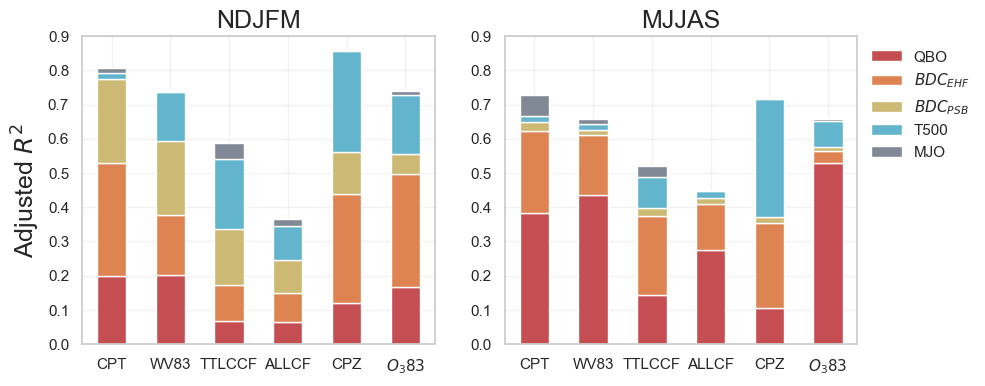

In [ ]:
seasonal_predictor_and_target_dfs = [djf_predictors_and_target_df, jja_predictors_and_target_df]

# set the figure size
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs_flat = axs.flatten()
season_strings = ['NDJFM', 'MJJAS']
for predictors_and_target_df_idx in range(0, 2):
    predictors_and_target_df = seasonal_predictor_and_target_dfs[predictors_and_target_df_idx]
    axs_obj = axs_flat[predictors_and_target_df_idx]
    # Plot correlation Matrix
    LSD = predictors_and_target_df[['QBO', '$BDC_{EHF}$', '$BDC_{PSB}$', 'T500', 'MJO']]

    CPT = predictors_and_target_df['CPT']
    WV = predictors_and_target_df['WV83']
    TTLCCF = predictors_and_target_df['TTLCCF']
    AllCF = predictors_and_target_df['ALLCF']
    CPZ = predictors_and_target_df['CPZ']
    O3 = predictors_and_target_df['$O_{3}83$']


    targets = [CPT, WV, TTLCCF, AllCF, CPZ, O3]
    partitioned_variances = []
    for target_idx, TargetVariable in enumerate(targets):
        if target_idx == 1:
            LSD_ = LSD[:-1]
            TargetVariable_ = TargetVariable[:-1]

            lm = pg.linear_regression(LSD_, TargetVariable_, add_intercept=True, relimp=True)
        else:
            lm = pg.linear_regression(LSD, TargetVariable, add_intercept=True, relimp=True)

        partitioned_adjr2 = lm.relimp.values[1:]
        partitioned_variances.append(partitioned_adjr2)

    partitioned_variances = pd.DataFrame(partitioned_variances, 
                                        index=['CPT', 'WV83', 'TTLCCF', 'ALLCF', 'CPZ', '$O_{3}83$'], 
                                        columns=['QBO', '$BDC_{EHF}$', '$BDC_{PSB}$', 'T500', 'MJO'])

    #barchart colors
    bar_colors = ['#c44e52', '#dd8452','#ccb974', '#63b5cd', '#828996']
    sequential_colors = sns.color_palette(bar_colors, 5)

    # set plot style: grey grid in the background:
    sns.set(style="whitegrid")

    # sum of total explained variance (equal to models R2)
    total = np.nansum(partitioned_variances, axis=1,)
    
    #create stacked bar chart
    if predictors_and_target_df_idx == 0:
        partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0, ax=axs_obj, legend=False)
        axs_obj.set_ylabel('Adjusted $R^{2}$', fontsize=18)
    else:
        partitioned_variances.plot(kind='bar', stacked=True, color=sequential_colors, rot=0, ax=axs_obj, legend=True)
    axs_obj.set_ylim(0,0.9)
    axs_obj.grid(alpha=0.25)
    axs_obj.set_title(season_strings[predictors_and_target_df_idx], fontsize=18)

axs_obj.legend(loc='upper left', bbox_to_anchor=(1., 1.0), frameon=False)
#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/TTLVariabilityFinalFigures/Figure9.png', dpi=300)

In [ ]:
def season_finder_profiles(calendar, m1, m2, m3, m4, m5):
    """ 
    Data should be indexed as (years, months)
    """
    total_djf_anoms_list = [calendar[:,m1], calendar[:,m2], 
                            calendar[:,m3], calendar[:,m4],
                            calendar[:,m5]]
    total_djf_anoms = np.swapaxes(total_djf_anoms_list, 0,1)
    shape = np.shape(total_djf_anoms)
    total_djf_timeseries = np.reshape(total_djf_anoms, (shape[0]*shape[1],shape[2], shape[3]))
    return(total_djf_timeseries)

temp_prof_anoms = temp_profs - np.nanmean(temp_profs, axis=0)
temp_prof_anoms_zm = np.nanmean(temp_prof_anoms, axis=3)
global_zm_temp_anoms = np.nanmean(np.reshape(temp_prof_anoms_zm, (16,12,36,2,350)), axis=3)
NDJFM_Profiles = season_finder_profiles(global_zm_temp_anoms, 0,1,2,10,11)[3:]

MJJAS_Profiles = season_finder_profiles(global_zm_temp_anoms, 4,5,6,7,8)[1:]
cpz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/cpz_maps_zm_annual_mean.npy')
lrz_maps_zm_annual_mean = np.load(project_path + '/tempmaps/lrz_maps_zm_annual_mean.npy')

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


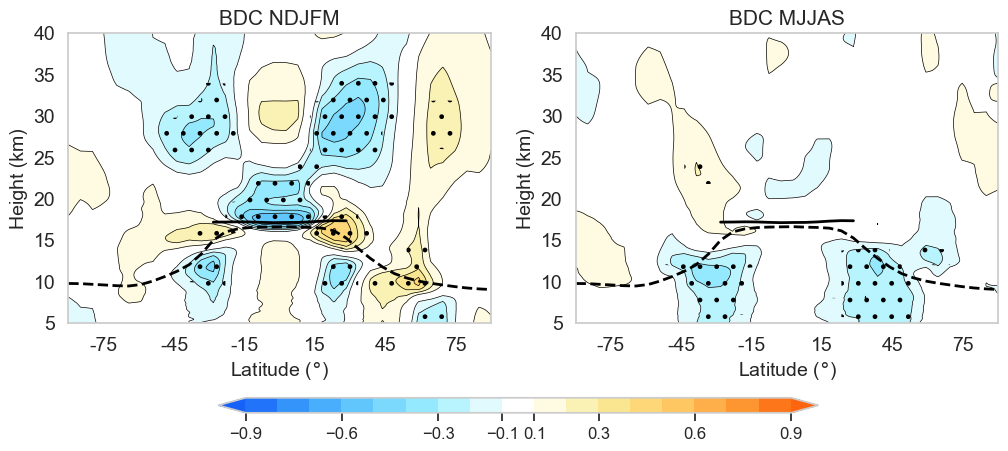

In [ ]:
def profile_correlator(pc, varmap):
    pc = pc/np.nanstd(pc)
    r_map = []
    sig_map = []
    for x in range(0, len(varmap[0,:])):
        r_x = []
        sig_x = []
        for y in range(len(varmap[0,0,:])):        
            temp_series = varmap[:,x,y]
            temp_series_no_nans = temp_series[~np.isnan(temp_series)]
            pc_non_nans = pc[~np.isnan(temp_series)]
            
            try:
                N = len(temp_series)
                r = stats.pearsonr(temp_series_no_nans[:], pc_non_nans[:])[0]
                r1_autocorrelation = stats.pearsonr(temp_series_no_nans[1:], temp_series_no_nans[:-1])[0]
                r2_autocorrelation = stats.pearsonr(pc_non_nans[1:], pc_non_nans[:-1])[0]
                N_star = N*((1-r1_autocorrelation*r2_autocorrelation)/
                            (1+r1_autocorrelation*r2_autocorrelation))
                tcrit = stats.t.ppf(1-0.025, N_star)
                t = (r*np.sqrt(N_star - 2))/(np.sqrt(1 - r**2))
                if abs(t) - tcrit > 0:
                    significant = 1
                else:
                    significant = 0

            except:
                r = np.NaN
                significant = 0
            r_x.append(r)
            sig_x.append(significant)
        r_map.append(r_x)
        sig_map.append(sig_x)
    return(np.transpose(r_map), np.transpose(sig_map))

from matplotlib.colors import LinearSegmentedColormap
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#ttl_cirrus_cf_ts, allcfTCF_ts
cpt_corr_map = profile_correlator(up100_bw, NDJFM_Profiles)
cpz_corr_map = profile_correlator(up100_bs, MJJAS_Profiles)
corr_maps = [cpt_corr_map, cpz_corr_map]
titles = ['BDC NDJFM', 'BDC MJJAS']
#titles = ['TTLCCF', 'ALLCF']
levels = np.array([-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9])/10

fig, axs = plt.subplots(1,2, figsize=(12,5))
for i in range(2):
    corr_map = corr_maps[i][0]
    sig_map = corr_maps[i][1]
    axs[i].set_title(titles[i], fontsize=15)
    im = axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, cmap=custom_cmap, extend='both')
    axs[i].contour(np.linspace(-90,90,36), np.linspace(5,40,350), corr_map, levels=levels, colors='black', 
                linewidths=0.5, linestyles=np.where(levels >= 0, "-", "-"), extend='both')
    axs[i].contourf(np.linspace(-90,90,36), np.linspace(5,40,350), sig_map, levels=[-1, 0, 1], colors='none', hatches=[None,'.'])
    axs[i].plot(np.linspace(-90,90,36)[12:24], cpz_maps_zm_annual_mean[12:24], color='black', linewidth=2)
    axs[i].plot(np.linspace(-90,90,36), lrz_maps_zm_annual_mean, color='black', linewidth=2, linestyle='dashed')
    axs[i].set_yticks([5,10,15,20,25,30, 35,40])
    axs[i].set_yticklabels(labels=['5','10','15','20','25','30', '35', '40'], fontsize=14)
    axs[i].set_xticks([-75, -45, -15,  15, 45, 75])
    axs[i].set_xticklabels(labels=['-75', '-45', '-15',  '15', '45', '75'], fontsize=14)
    axs[i].grid(color='black', alpha=0.25)
    axs[i].set_xlabel('Latitude ($\degree$)', fontsize=14)
    axs[i].set_ylabel('Height (km)', fontsize=14)
    
fig.subplots_adjust(bottom=0.3)
cbar_cf = fig.add_axes([0.25, 0.12, 0.5, 0.03])
fig.colorbar(im, cax=cbar_cf, orientation='horizontal', ticks=[-.9, -.6,-.3,-.1,.1, .3,.6,.9])
cbar_cf.tick_params(labelsize=12)


In [107]:
print(np.shape(NDJFM_Profiles))

(77, 36, 350)
